In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    precision_recall_curve,
    auc,
    confusion_matrix,
    roc_curve
)


In [3]:
# Load data
df = pd.read_csv("diabetes_binary_health_indicators_BRFSS2015.csv")

# Peek at data
print(df.shape)
print(df.head())
print(df.info())
print(df['Diabetes_binary'].value_counts(normalize=True))


(253680, 22)
   Diabetes_binary  HighBP  HighChol  CholCheck   BMI  Smoker  Stroke  \
0              0.0     1.0       1.0        1.0  40.0     1.0     0.0   
1              0.0     0.0       0.0        0.0  25.0     1.0     0.0   
2              0.0     1.0       1.0        1.0  28.0     0.0     0.0   
3              0.0     1.0       0.0        1.0  27.0     0.0     0.0   
4              0.0     1.0       1.0        1.0  24.0     0.0     0.0   

   HeartDiseaseorAttack  PhysActivity  Fruits  ...  AnyHealthcare  \
0                   0.0           0.0     0.0  ...            1.0   
1                   0.0           1.0     0.0  ...            0.0   
2                   0.0           0.0     1.0  ...            1.0   
3                   0.0           1.0     1.0  ...            1.0   
4                   0.0           1.0     1.0  ...            1.0   

   NoDocbcCost  GenHlth  MentHlth  PhysHlth  DiffWalk  Sex   Age  Education  \
0          0.0      5.0      18.0      15.0       1.0 

In [4]:
X = df.drop(columns=['Diabetes_binary'])
y = df['Diabetes_binary']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [5]:
lr = LogisticRegression(max_iter=500, class_weight='balanced', solver='liblinear')
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
y_prob = lr.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


              precision    recall  f1-score   support

         0.0       0.95      0.73      0.82     43667
         1.0       0.31      0.76      0.44      7069

    accuracy                           0.73     50736
   macro avg       0.63      0.74      0.63     50736
weighted avg       0.86      0.73      0.77     50736

ROC-AUC: 0.8196336493492529


In [6]:
roc = roc_auc_score(y_test, y_prob)

precision, recall, _ = precision_recall_curve(y_test, y_prob)
pr_auc = auc(recall, precision)

print("ROC-AUC:", roc)
print("PR-AUC:", pr_auc)


ROC-AUC: 0.8196336493492529
PR-AUC: 0.3924625495012163


In [7]:
# Train the model
rf = RandomForestClassifier(
    n_estimators=300,         # More trees = more stable performance
    max_depth=None,           # Let trees grow fully
    min_samples_split=10,     # Prevent overfitting
    class_weight='balanced',  # Handle class imbalance
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

# Predictions & probabilities
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

# Metrics
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC RF:", roc_auc_score(y_test, y_prob_rf))

precision, recall, _ = precision_recall_curve(y_test, y_prob_rf)
pr_auc = auc(recall, precision)
print("PR-AUC RF:", pr_auc)


              precision    recall  f1-score   support

         0.0       0.91      0.88      0.90     43667
         1.0       0.40      0.48      0.44      7069

    accuracy                           0.83     50736
   macro avg       0.66      0.68      0.67     50736
weighted avg       0.84      0.83      0.83     50736

ROC-AUC RF: 0.8137360026955636
PR-AUC RF: 0.40367138643750466


In [8]:
#Smaller threshold
threshold = 0.3
y_pred_thresh = (y_prob_rf >= threshold).astype(int)

print(confusion_matrix(y_test, y_pred_thresh))
print(classification_report(y_test, y_pred_thresh))


[[30747 12920]
 [ 1563  5506]]
              precision    recall  f1-score   support

         0.0       0.95      0.70      0.81     43667
         1.0       0.30      0.78      0.43      7069

    accuracy                           0.71     50736
   macro avg       0.63      0.74      0.62     50736
weighted avg       0.86      0.71      0.76     50736



In [9]:
#Find the most important features to try a reduced model
importances = rf.feature_importances_
feature_names = X.columns
sorted_idx = np.argsort(importances)[::-1]

print("Top 10 Features by Importance:")
for idx in sorted_idx[:10]:
    print(f"{feature_names[idx]}: {importances[idx]:.4f}")


Top 10 Features by Importance:
BMI: 0.1618
GenHlth: 0.1351
Age: 0.1197
HighBP: 0.1074
Income: 0.0696
PhysHlth: 0.0629
HighChol: 0.0525
MentHlth: 0.0481
Education: 0.0461
DiffWalk: 0.0312


In [10]:
# Random Forest with top 10 features
top_features = ['BMI', 'GenHlth', 'Age', 'HighBP', 'Income',
                'PhysHlth', 'HighChol', 'MentHlth', 'Education', 'DiffWalk']

X_train_top = X_train[top_features]
X_test_top  = X_test[top_features]

# Train reduced RF
rf_top = RandomForestClassifier(
    n_estimators=300,
    min_samples_split=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf_top.fit(X_train_top, y_train)

# Predictions & probabilities
y_pred_rf_top = rf_top.predict(X_test_top)
y_prob_rf_top = rf_top.predict_proba(X_test_top)[:, 1]

# Metrics at default threshold
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc

print("=== Reduced RF (Top 10 Features) @ Default Threshold ===")
print(classification_report(y_test, y_pred_rf_top))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf_top))

precision, recall, _ = precision_recall_curve(y_test, y_prob_rf_top)
pr_auc = auc(recall, precision)
print("PR-AUC:", pr_auc)

# Apply threshold tuning (0.3)
threshold = 0.3
y_pred_thresh_top = (y_prob_rf_top >= threshold).astype(int)
print("\n=== Reduced RF (Top 10 Features) @ Threshold 0.3 ===")
print(classification_report(y_test, y_pred_thresh_top))


=== Reduced RF (Top 10 Features) @ Default Threshold ===
              precision    recall  f1-score   support

         0.0       0.91      0.85      0.88     43667
         1.0       0.36      0.51      0.42      7069

    accuracy                           0.81     50736
   macro avg       0.64      0.68      0.65     50736
weighted avg       0.84      0.81      0.82     50736

ROC-AUC: 0.791729016561486
PR-AUC: 0.3651806052466732

=== Reduced RF (Top 10 Features) @ Threshold 0.3 ===
              precision    recall  f1-score   support

         0.0       0.95      0.68      0.79     43667
         1.0       0.28      0.77      0.41      7069

    accuracy                           0.69     50736
   macro avg       0.61      0.72      0.60     50736
weighted avg       0.85      0.69      0.74     50736



In [11]:
# Random Forest with Top 5 features
top5_features = ['BMI', 'GenHlth', 'Age', 'HighBP', 'Income']

X_train_top5 = X_train[top5_features]
X_test_top5  = X_test[top5_features]

# Train reduced RF
rf_top5 = RandomForestClassifier(
    n_estimators=300,
    min_samples_split=10,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf_top5.fit(X_train_top5, y_train)

# Predictions @ default threshold
y_pred_rf_top5 = rf_top5.predict(X_test_top5)
y_prob_rf_top5 = rf_top5.predict_proba(X_test_top5)[:, 1]

from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, auc

print("=== RF Top 5 Features @ Default Threshold ===")
print(classification_report(y_test, y_pred_rf_top5))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf_top5))

precision, recall, _ = precision_recall_curve(y_test, y_prob_rf_top5)
pr_auc = auc(recall, precision)
print("PR-AUC:", pr_auc)

# Threshold tuning (0.3)
threshold = 0.3
y_pred_thresh_top5 = (y_prob_rf_top5 >= threshold).astype(int)
print("\n=== RF Top 5 Features @ Threshold 0.3 ===")
print(classification_report(y_test, y_pred_thresh_top5))


=== RF Top 5 Features @ Default Threshold ===
              precision    recall  f1-score   support

         0.0       0.93      0.75      0.83     43667
         1.0       0.30      0.66      0.41      7069

    accuracy                           0.74     50736
   macro avg       0.61      0.70      0.62     50736
weighted avg       0.84      0.74      0.77     50736

ROC-AUC: 0.7767157953347998
PR-AUC: 0.3439186265015925

=== RF Top 5 Features @ Threshold 0.3 ===
              precision    recall  f1-score   support

         0.0       0.96      0.58      0.72     43667
         1.0       0.24      0.83      0.38      7069

    accuracy                           0.61     50736
   macro avg       0.60      0.71      0.55     50736
weighted avg       0.86      0.61      0.67     50736



In [14]:
def threshold_metrics(y_true, y_prob, thresholds):
    rows = []
    for t in thresholds:
        y_pred = (y_prob >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        prec = tp / (tp + fp) if (tp+fp) else 0.0
        rec  = tp / (tp + fn) if (tp+fn) else 0.0
        spec = tn / (tn + fp) if (tn+fp) else 0.0
        acc  = (tp + tn) / (tp + tn + fp + fn)
        f1   = 2*prec*rec / (prec+rec) if (prec+rec) else 0.0
        npv  = tn / (tn + fn) if (tn+fn) else 0.0
        rows.append({"threshold": t, "precision": prec, "recall": rec, "specificity": spec,
                     "f1": f1, "accuracy": acc, "ppv": prec, "npv": npv,
                     "TP": tp, "FP": fp, "FN": fn, "TN": tn})
    df = pd.DataFrame(rows)
    return df

def pr_auc(y_true, y_prob):
    p, r, _ = precision_recall_curve(y_true, y_prob)
    return auc(r, p)

thresholds = [0.50, 0.40, 0.35, 0.30, 0.25, 0.20]

tables = {}
probs = {
    "LogReg (all 21)": y_prob,
    "RF (all 21)":     y_prob_rf,
    "RF (top 10)":     y_prob_rf_top,
    "RF (top 5)":      y_prob_rf_top5
}

for name, yp in probs.items():
    tbl = threshold_metrics(y_test.values, yp, thresholds)
    tbl.insert(1, "ROC_AUC", roc_auc_score(y_test, yp))
    tbl.insert(2, "PR_AUC",  pr_auc(y_test, yp))
    tables[name] = tbl

# Show tables
for name, tbl in tables.items():
    print(f"\n=== {name} ===")
    print(tbl.to_string(index=False))



=== LogReg (all 21) ===
 threshold  ROC_AUC   PR_AUC  precision   recall  specificity       f1  accuracy      ppv      npv   TP    FP   FN    TN
      0.50 0.819634 0.392463   0.310713 0.761069     0.726681 0.441273  0.731473 0.310713 0.949463 5380 11935 1689 31732
      0.40 0.819634 0.392463   0.274027 0.853869     0.633797 0.414902  0.664459 0.274027 0.964018 6036 15991 1033 27676
      0.35 0.819634 0.392463   0.256269 0.887679     0.582957 0.397718  0.625414 0.256269 0.969752 6275 18211  794 25456
      0.30 0.819634 0.392463   0.238304 0.917244     0.525385 0.378318  0.579983 0.238304 0.975135 6484 20725  585 22942
      0.25 0.819634 0.392463   0.221118 0.944405     0.461470 0.358337  0.528757 0.221118 0.980870 6676 23516  393 20151
      0.20 0.819634 0.392463   0.203021 0.965766     0.386264 0.335512  0.467006 0.203021 0.985855 6827 26800  242 16867

=== RF (all 21) ===
 threshold  ROC_AUC   PR_AUC  precision   recall  specificity       f1  accuracy      ppv      npv   TP    

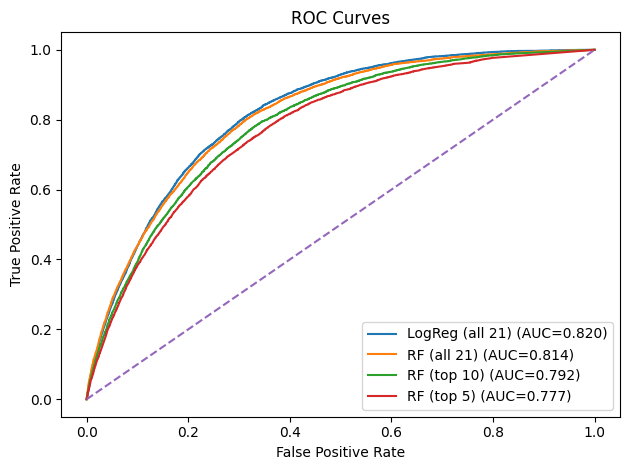

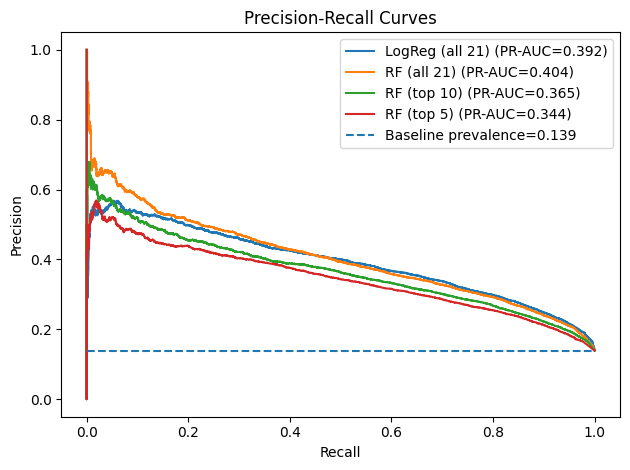

In [15]:
# ROC curves
plt.figure()
for name, yp in probs.items():
    fpr, tpr, _ = roc_curve(y_test, yp)
    plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc_score(y_test, yp):.3f})")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend()
plt.tight_layout()
plt.show()

# PR curves
plt.figure()
for name, yp in probs.items():
    prec, rec, _ = precision_recall_curve(y_test, yp)
    plt.plot(rec, prec, label=f"{name} (PR-AUC={pr_auc(y_test, yp):.3f})")
base = (y_test==1).mean()
plt.hlines(base, 0, 1, linestyles='--', label=f"Baseline prevalence={base:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves")
plt.legend()
plt.tight_layout()
plt.show()
